In [1]:
from sklearn.cluster import KMeans
import cv2 as cv
import matplotlib.pyplot as plt
from numpy.typing import *
from typing import *
import numpy as np

# Các bước
- color quantization hình ảnh, đưa hình ảnh về ít màu hơn
- chia ảnh sau khi phân cụm thành các block 4x4
- mã hóa block 4x4 theo bảng màu, bảng màu có được do sử dụng center của thuật toán Kmeans sau khi phân cụm
- ghép các block lại với nhau ta được 1 bức ảnh intra coding sau khi mã hóa với các chỉ số index của bảng màu

In [2]:
def color_quantization(image, num_clusters):
    # Chuyển đổi ảnh sang định dạng LAB
    
    # Chuyển đổi ảnh sang ma trận 2D
    flattened_image = image.reshape((-1, 3))
    
    # Sử dụng thuật toán k-means để phân cụm giá trị màu
    kmeans = KMeans(n_clusters=num_clusters)
    labels = kmeans.fit_predict(flattened_image)
    
    # Tạo một mảng giá trị màu quantized dựa trên các trung tâm cụm
    quantized_colors = kmeans.cluster_centers_.astype(int)
    
    # Gán mỗi điểm ảnh vào cụm tương ứng
    quantized_image = quantized_colors[labels].reshape(image.shape)
    
    # Chuyển đổi lại ảnh sang định dạng ban đầu
    
    return kmeans.cluster_centers_, quantized_image


In [3]:
def split_image_into_blocks(image: ArrayLike, block_size: Any) -> ArrayLike:
    '''
    Split an image into smaller blocks of the specified block size. 
    The function takes an input image and a block size, which can be either an integer or a tuple of two integers representing the height and width of the blocks. 

    Args:
        - image: input image as a numpy array.
        - block_size: the size of the blocks, either an integer or a tuple of two integers representing the height and width of the blocks.

    Returns:
        - blocks: a numpy array containing the image divided into smaller blocks of the specified size.
    '''
    if isinstance(block_size,int):
        block_height =  block_width = block_size
    else : 
        assert len(block_size) == 2 
        block_height, block_width = block_size
    height, width = image.shape[:2]
    
    n_blocks_height = height // block_height
    n_blocks_width = width // block_width
    blocks = np.zeros((n_blocks_height, n_blocks_width, block_height, block_width), dtype=image.dtype)
    for i in range(n_blocks_height):
        for j in range(n_blocks_width):
            block = image[i*block_height:(i+1)*block_height, j*block_width:(j+1)*block_width]
            blocks[i, j] = block
    return blocks

In [4]:
def palette_mode(block, palette):
    new_block = np.zeros_like(block)
    for i in range(block.shape[0]):
        for j in range(block.shape[1]):
            new_block[i,j] = np.where(block[i,j] == palette)[0]
    
    return new_block

In [5]:
def intra_coding(img, palette, block_size = 4):
    if isinstance(block_size,int):
        block_height =  block_width = block_size
    else : 
        assert len(block_size) == 2 
        block_height, block_width = block_size
    blocks = split_image_into_blocks(img, block_size)
    intra_img = np.zeros_like(img)
    for i in range(blocks.shape[0]):
        for j in range(blocks.shape[1]):
            mb_block  = blocks[i,j]
            intra_block = palette_mode(mb_block, palette)
            intra_img[i * block_height : (i + 1)*block_height, j * block_width : (j + 1)* block_width] = intra_block
    return intra_img

In [6]:
# Đọc ảnh đầu vào
image = cv.imread('img.jpg')
image = cv.resize(image, (1284, 720))
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
# Thực hiện quantization với 8 cụm
center, quantized_image = color_quantization(image, num_clusters = 16)

r_quantized_image, g_quantized_image, b_quantized_image = cv.split(quantized_image)
center = center.astype(np.uint8)
center

c:\Users\PC\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([[125, 138,  45],
       [ 76,  80,  58],
       [230, 224,  67],
       [ 32,  41,  33],
       [ 68, 114, 118],
       [ 96, 117,  42],
       [155, 164,  50],
       [131, 145, 114],
       [ 44,  60,  55],
       [ 55,  68,  33],
       [ 74,  94,  35],
       [201, 213, 159],
       [ 96, 112,  79],
       [ 91, 169, 189],
       [ 56,  85,  82],
       [192, 192,  57]], dtype=uint8)

In [7]:
r_center, g_center, b_center = center[:,0], center[:,1], center[:,2]

r_intra_img = intra_coding(r_quantized_image, r_center)
g_intra_img = intra_coding(g_quantized_image, g_center)
b_intra_img = intra_coding(b_quantized_image, b_center)
intra_img = cv.merge([r_intra_img, g_intra_img, b_intra_img])


(-0.5, 1283.5, 719.5, -0.5)

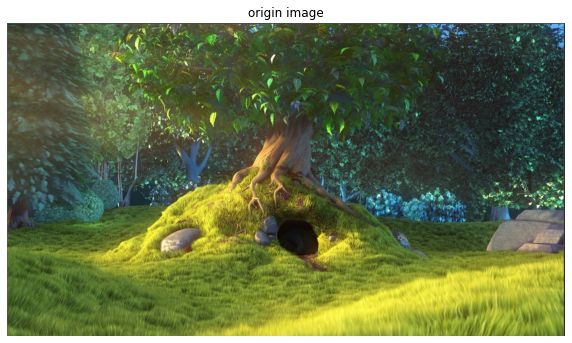

In [ ]:
plt.figure(figsize=(10,8))
plt.imshow(image)
plt.title('origin image')
plt.axis('off')

(-0.5, 1283.5, 719.5, -0.5)

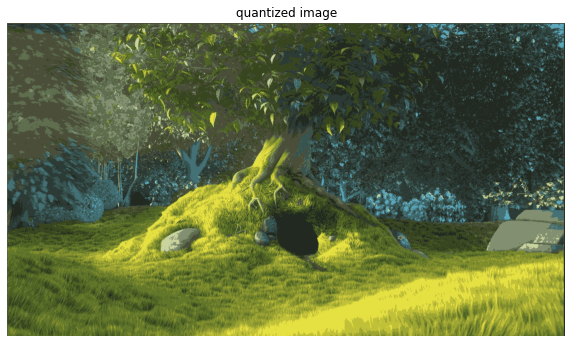

In [ ]:
plt.figure(figsize=(10,8))
plt.imshow(quantized_image)
plt.title('quantized image')
plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1283.5, 719.5, -0.5)

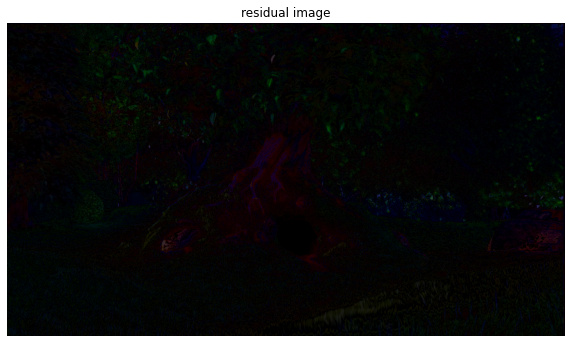

In [ ]:
plt.figure(figsize=(10,8))
plt.imshow(image - quantized_image)
plt.title('residual image')
plt.axis('off')

In [ ]:
intra_img.transpose([2,0,1])

array([[[ 9, 12, 12, ...,  0, 12, 12],
        [ 9, 12, 12, ..., 10,  5, 12],
        [ 9,  5,  5, ...,  0, 12, 12],
        ...,
        [12,  9, 15, ...,  9,  1,  1],
        [12,  9, 15, ..., 12,  1,  1],
        [12,  9, 15, ..., 12,  1,  1]],

       [[ 9, 12, 12, ...,  0, 12, 12],
        [ 9, 12, 12, ..., 10,  5, 12],
        [ 9,  5,  5, ...,  0, 12, 12],
        ...,
        [12,  9, 15, ...,  9,  1,  1],
        [12,  9, 15, ..., 12,  1,  1],
        [12,  9, 15, ..., 12,  1,  1]],

       [[ 9, 12, 12, ...,  0, 12, 12],
        [ 9, 12, 12, ..., 10,  5, 12],
        [ 9,  5,  5, ...,  0, 12, 12],
        ...,
        [12,  9, 15, ...,  9,  1,  1],
        [12,  9, 15, ..., 12,  1,  1],
        [12,  9, 15, ..., 12,  1,  1]]], dtype=int32)